## 1. libraries import and setup

In [1]:
from pathlib import Path
import importlib.util
import sys
import rioxarray as rxr
import tensorflow as tf
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\DOPs
created directory data\raw_data\laz_ALS
created directory data\raw_data\laz_DAP
created directory data\raw_data\dtm_tiles
created directory data\raw_data\test_tiles
created directory data\processed_data\DOPs
created directory data\processed_data\nDSMs_ALS
created directory data\processed_data\nDSMs_DAP
created directory data\processed_data\laz_ALS
created directory data\processed_data\laz_DAP
created directory data\processed_data\datasets
created directory data\processed_data\models
created directory data\processed_data\gap_polygons_ALS
created directory data\processed_data\gap_polygons_DAP
created directory data\metadata
created directory src
created directory scripts
created directory output


## 2. data reading and preparation

In [4]:
# read preprocessed dataset (TDOP + nDSM for training with gap mask)
train_ds = rxr.open_rasterio(processed_data_dir / 'datasets' / 'train_ds.tif',
                             band_as_variable=True)

# use the long_names as variable names 
# (previously assigned in script 'data_preparation')
for var_name in train_ds.data_vars:
    long_name = train_ds[var_name].attrs['long_name']
    train_ds = train_ds.rename({var_name: long_name})

train_ds

<xarray.Dataset>
Dimensions:      (x: 7000, y: 10501)
Coordinates:
  * x            (x) float64 5.445e+05 5.445e+05 5.445e+05 ... 5.48e+05 5.48e+05
  * y            (y) float64 5.733e+06 5.733e+06 ... 5.728e+06 5.728e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 ...
    green        (y, x) float32 ...
    blue         (y, x) float32 ...
    nir          (y, x) float32 ...
    ndsm         (y, x) float32 ...
    gap_mask     (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area

In [5]:
# import data generator
src_dir = Path.cwd().parent / 'src'
sys.path.append(str(src_dir))
from cidg import CustomImageDataGenerator

# define tile size
tilesize = 224

# create an instance of the data generator
# hand over the training dataset (TDOP + nDSM with gap mask)
cidg_training   = CustomImageDataGenerator(train_ds, tilesize, sampletype='training')
cidg_validation = CustomImageDataGenerator(train_ds, tilesize, sampletype='validation')

In [6]:
# get preprocessing of desired backbone
preprocess_input = sm.get_preprocessing('resnet34')

# preprocess input
cidg_train_preprocessed = preprocess_input(cidg_training)
cidg_val_preprocessed = preprocess_input(cidg_validation)

## 3. model initialization and training

In [6]:
# define number of input channels (RGBI + nDSM)
channels = 5

# define model:
# U-Net with ResNet 34 as backbone and pretrained weights
base_model = sm.Unet(
    backbone_name='resnet34',
    encoder_weights='imagenet')

# add extra convolution layer to map N -> 3 channels data 
# and train with pretrained weights
# --> see documentation of the segmentation_models library 
# (https://segmentation-models.readthedocs.io/en/latest/tutorial.html?highlight=preprocessing#training-with-non-rgb-data)
inp = Input(shape=(tilesize, tilesize, channels))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

# compile with Adam optimizer and Binary Cross Entropy
# use Intersection over Union (IoU) 
# and F1-score as accuarcy measures
model.compile(optimizer='adam',
              loss=sm.losses.BinaryCELoss(),
              metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

In [7]:
# implement stop of training when validation loss
# has stopped improving for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1-score',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

# callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    str(processed_data_dir / 'models' / 'resnet34_unet_rgbi_ndsm'), 
    monitor='val_f1-score', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

# callback to reduce the learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1-score', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001, 
    verbose=1,
    mode='max'
)

# training
model_history = model.fit(cidg_train_preprocessed,
                          validation_data=cidg_val_preprocessed,
                          epochs=100,
                          initial_epoch=0,
                          callbacks=[early_stopping, checkpoint, reduce_lr],
                          workers=multiprocessing.cpu_count() - 4)

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 0.2626 - iou_score: 0.0238 - f1-score: 0.0454  
Epoch 1: val_f1-score improved from -inf to 0.05603, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 3243s 71s/step - loss: 0.2626 - iou_score: 0.0238 - f1-score: 0.0454 - val_loss: 1.5950 - val_iou_score: 0.0296 - val_f1-score: 0.0560 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.1410 - iou_score: 0.2127 - f1-score: 0.3359  
Epoch 2: val_f1-score did not improve from 0.05603
46/46 [==============================] - 4711s 102s/step - loss: 0.1410 - iou_score: 0.2127 - f1-score: 0.3359 - val_loss: 0.7920 - val_iou_score: 0.0151 - val_f1-score: 0.0287 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.1228 - iou_score: 0.3365 - f1-score: 0.4959  
Epoch 3: val_f1-score did not improve from 0.05603
46/46 [==============================] - 4676s 102s/step - loss: 0.1228 - iou_score: 0.3365 - f1-score: 0.4959 - val_loss: 0.2262 - val_iou_score: 0.0079 - val_f1-score: 0.0154 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.1124 - iou_score: 0.3834

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 4696s 102s/step - loss: 0.1124 - iou_score: 0.3834 - f1-score: 0.5500 - val_loss: 0.2203 - val_iou_score: 0.0507 - val_f1-score: 0.0944 - lr: 0.0010
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.1057 - iou_score: 0.4124 - f1-score: 0.5811  
Epoch 5: val_f1-score improved from 0.09436 to 0.33208, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 4801s 104s/step - loss: 0.1057 - iou_score: 0.4124 - f1-score: 0.5811 - val_loss: 0.1803 - val_iou_score: 0.2041 - val_f1-score: 0.3321 - lr: 0.0010
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.1060 - iou_score: 0.3953 - f1-score: 0.5625  
Epoch 6: val_f1-score did not improve from 0.33208
46/46 [==============================] - 4980s 108s/step - loss: 0.1060 - iou_score: 0.3953 - f1-score: 0.5625 - val_loss: 0.2670 - val_iou_score: 0.0729 - val_f1-score: 0.1320 - lr: 0.0010
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.1013 - iou_score: 0.4191 - f1-score: 0.5864  
Epoch 7: val_f1-score did not improve from 0.33208
46/46 [==============================] - 4996s 109s/step - loss: 0.1013 - iou_score: 0.4191 - f1-score: 0.5864 - val_loss: 0.2240 - val_iou_score: 0.1045 - val_f1-score: 0.1816 - lr: 0.0010
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.0940 - iou_score: 0.444

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 5013s 109s/step - loss: 0.0940 - iou_score: 0.4440 - f1-score: 0.6103 - val_loss: 0.1509 - val_iou_score: 0.3101 - val_f1-score: 0.4656 - lr: 0.0010
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 0.0893 - iou_score: 0.4684 - f1-score: 0.6330  
Epoch 9: val_f1-score did not improve from 0.46559
46/46 [==============================] - 5052s 110s/step - loss: 0.0893 - iou_score: 0.4684 - f1-score: 0.6330 - val_loss: 0.1499 - val_iou_score: 0.1817 - val_f1-score: 0.2997 - lr: 0.0010
Epoch 10/100
46/46 [==============================] - ETA: 0s - loss: 0.0871 - iou_score: 0.4839 - f1-score: 0.6481  
Epoch 10: val_f1-score improved from 0.46559 to 0.52133, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 4830s 105s/step - loss: 0.0871 - iou_score: 0.4839 - f1-score: 0.6481 - val_loss: 0.1287 - val_iou_score: 0.3600 - val_f1-score: 0.5213 - lr: 0.0010
Epoch 11/100
46/46 [==============================] - ETA: 0s - loss: 0.0847 - iou_score: 0.5055 - f1-score: 0.6694  
Epoch 11: val_f1-score improved from 0.52133 to 0.60012, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 5155s 112s/step - loss: 0.0847 - iou_score: 0.5055 - f1-score: 0.6694 - val_loss: 0.1219 - val_iou_score: 0.4346 - val_f1-score: 0.6001 - lr: 0.0010
Epoch 12/100
46/46 [==============================] - ETA: 0s - loss: 0.0823 - iou_score: 0.5164 - f1-score: 0.6796  
Epoch 12: val_f1-score did not improve from 0.60012
46/46 [==============================] - 5372s 117s/step - loss: 0.0823 - iou_score: 0.5164 - f1-score: 0.6796 - val_loss: 0.1487 - val_iou_score: 0.4105 - val_f1-score: 0.5684 - lr: 0.0010
Epoch 13/100
46/46 [==============================] - ETA: 0s - loss: 0.0754 - iou_score: 0.5509 - f1-score: 0.7087  
Epoch 13: val_f1-score improved from 0.60012 to 0.61195, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\asse

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 5320s 116s/step - loss: 0.0754 - iou_score: 0.5509 - f1-score: 0.7087 - val_loss: 0.1265 - val_iou_score: 0.4530 - val_f1-score: 0.6120 - lr: 0.0010
Epoch 14/100
46/46 [==============================] - ETA: 0s - loss: 0.0704 - iou_score: 0.5793 - f1-score: 0.7325  
Epoch 14: val_f1-score improved from 0.61195 to 0.61725, saving model to P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new
INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 5326s 116s/step - loss: 0.0704 - iou_score: 0.5793 - f1-score: 0.7325 - val_loss: 0.1357 - val_iou_score: 0.4555 - val_f1-score: 0.6173 - lr: 0.0010
Epoch 15/100
46/46 [==============================] - ETA: 0s - loss: 0.0673 - iou_score: 0.5973 - f1-score: 0.7469  
Epoch 15: val_f1-score did not improve from 0.61725
46/46 [==============================] - 5380s 117s/step - loss: 0.0673 - iou_score: 0.5973 - f1-score: 0.7469 - val_loss: 0.1673 - val_iou_score: 0.2729 - val_f1-score: 0.4172 - lr: 0.0010
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.0621 - iou_score: 0.6201 - f1-score: 0.7645  
Epoch 16: val_f1-score did not improve from 0.61725
46/46 [==============================] - 5324s 116s/step - loss: 0.0621 - iou_score: 0.6201 - f1-score: 0.7645 - val_loss: 0.1639 - val_iou_score: 0.2933 - val_f1-score: 0.4450 - lr: 0.0010
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.0586 - iou_score: 

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\models\resnet34_unet_rgbi_ndsm_new\assets


46/46 [==============================] - 5365s 117s/step - loss: 0.0540 - iou_score: 0.6675 - f1-score: 0.8000 - val_loss: 0.1433 - val_iou_score: 0.4755 - val_f1-score: 0.6377 - lr: 0.0010
Epoch 20/100
46/46 [==============================] - ETA: 0s - loss: 0.0511 - iou_score: 0.6842 - f1-score: 0.8121  
Epoch 20: val_f1-score did not improve from 0.63773
46/46 [==============================] - 5317s 116s/step - loss: 0.0511 - iou_score: 0.6842 - f1-score: 0.8121 - val_loss: 0.1394 - val_iou_score: 0.4371 - val_f1-score: 0.5991 - lr: 0.0010
Epoch 21/100
46/46 [==============================] - ETA: 0s - loss: 0.0524 - iou_score: 0.6762 - f1-score: 0.8062  
Epoch 21: val_f1-score did not improve from 0.63773
46/46 [==============================] - 5290s 115s/step - loss: 0.0524 - iou_score: 0.6762 - f1-score: 0.8062 - val_loss: 0.1392 - val_iou_score: 0.4269 - val_f1-score: 0.5877 - lr: 0.0010
Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.0631 - iou_score: 

## 4. plots

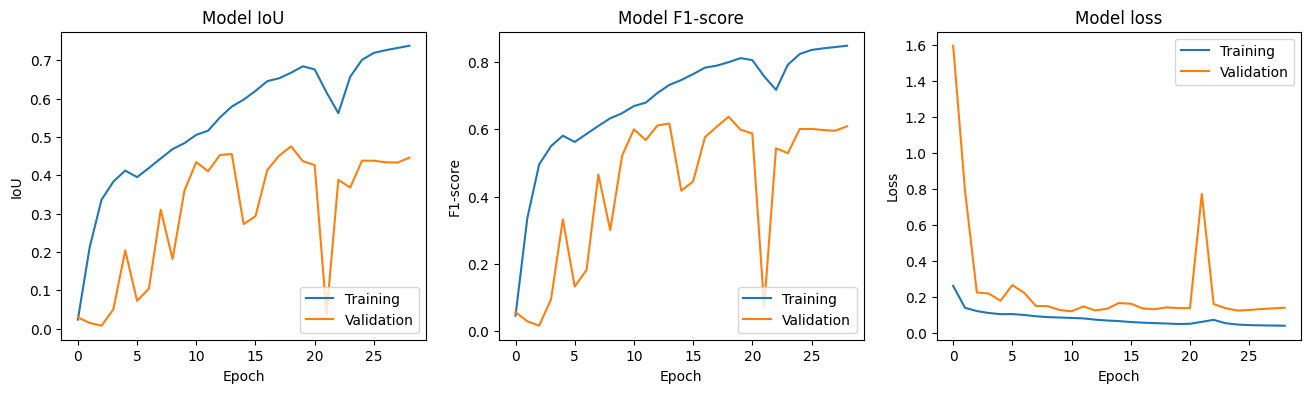

In [8]:
# plot IoU and loss over the epochs
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(model_history.history['iou_score'])
ax[0].plot(model_history.history['val_iou_score'])
ax[0].set_title('Model IoU')
ax[0].set_ylabel('IoU')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'], loc='lower right')

ax[1].plot(model_history.history['f1-score'])
ax[1].plot(model_history.history['val_f1-score'])
ax[1].set_title('Model F1-score')
ax[1].set_ylabel('F1-score')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'], loc='lower right')

ax[2].plot(model_history.history['loss'])
ax[2].plot(model_history.history['val_loss'])
ax[2].set_title('Model loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [9]:
# get epoch with the best model (based on validation loss)
best_model_epoch = np.argmax(model_history.history['val_f1-score'])
epoch_number = best_model_epoch + 1

# print training IoU for the best epoch
print(f"Training IoU best model at epoch {epoch_number}: {round(model_history.history['iou_score'][best_model_epoch], 2)}")
# print validation IoU for the best epoch
print(f"Validation IoU best model at epoch {epoch_number}: {round(model_history.history['val_iou_score'][best_model_epoch], 2)}")
# print training F1-score for the best epoch
print(f"Training F1-score best model at epoch {epoch_number}: {round(model_history.history['f1-score'][best_model_epoch], 2)}")
# print validation F1-score for the best epoch
print(f"Validation F1-score best model at epoch {epoch_number}: {round(model_history.history['val_f1-score'][best_model_epoch], 2)}")
# print training loss for the best epoch
print(f"Training loss best model at epoch {epoch_number}: {round(model_history.history['loss'][best_model_epoch], 2)}")
# print validation loss for the best epoch
print(f"Validation loss best model at epoch {epoch_number}: {round(model_history.history['val_loss'][best_model_epoch], 2)}")

Training IoU best model at epoch 19: 0.67
Validation IoU best model at epoch 19: 0.48
Training F1-score best model at epoch 19: 0.8
Validation F1-score best model at epoch 19: 0.64
Training loss best model at epoch 19: 0.05
Validation loss best model at epoch 19: 0.14
